In [18]:
import json
import pandas as pd
from math import sin, sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


replace = {
    'm_fwd': 'Alpha Forward',
    'm_rev': 'Alpha Reverse',
    'm_swr': 'Alpha SWR',
    'm_freq': 'Alpha Frequency',
    'm_temp': 'Alpha Temperature',
    't_fwd': 'MC-200 Forward',
    't_rev': 'MC-200 Reverse',
    't_swr': 'MC-200 SWR',
}


def load_file(*files: str):
    data = {}
    for filename in files:
        with open(filename) as f:
            for line in f.readlines():
                if line.startswith('//'):
                    continue

                d = json.loads(line)

                # drop all the metadata and the raw sample values
                record = {
                    **d['location'],
                    # **d['data'],
                }

                def sim(a, b):
                    diff = abs(a - b)
                    avg = (a + b) / 2
                    return (diff / avg) * 100

                record['error_fwd'] = sim(d['data']['m_fwd'], d['data']['t_fwd'])
                record['error_rev'] = sim(d['data']['m_rev'], d['data']['t_rev'])
                record['error_swr'] = sim(d['data']['m_swr'], d['data']['t_swr'])

                for k, v in replace.items():
                    record[v] = d['data'][k]

                location = d['location']
                key = f"{location['ant']}:{location['freq']}:{location['power']}"
                data[key] = record

    df = pd.DataFrame.from_records(list(data.values()))

    return df


In [48]:
df = load_file('data.jsonl')
df = df.query('ant == 1')
df = df.query('freq == "14000000"')
df = df.drop('Alpha Frequency', axis=1)
df = df.drop('Alpha Temperature', axis=1)
# df = df.sort_values('error_swr', ascending=False)
# df = df.sort_values('error_fwd')
# df = df.filter(['error_fwd', 'error_rev', 'error_swr'], axis=1)
df = df.filter(['error_fwd', 'MC-200 Forward', 'Alpha Forward'], axis=1)
df

,error_fwd,MC-200 Forward,Alpha Forward
96,89.678989,1.820973,4.781478
97,0.647148,10.773507,10.704012
98,0.137703,14.772332,14.792688
99,1.192645,20.144456,19.905628
100,1.559991,26.507287,26.096976
101,3.610447,30.975366,29.876848
102,3.923451,36.617772,35.208733
103,5.876159,41.754184,39.370672
104,6.985347,55.353570,51.617422
105,7.185934,63.583864,59.173242


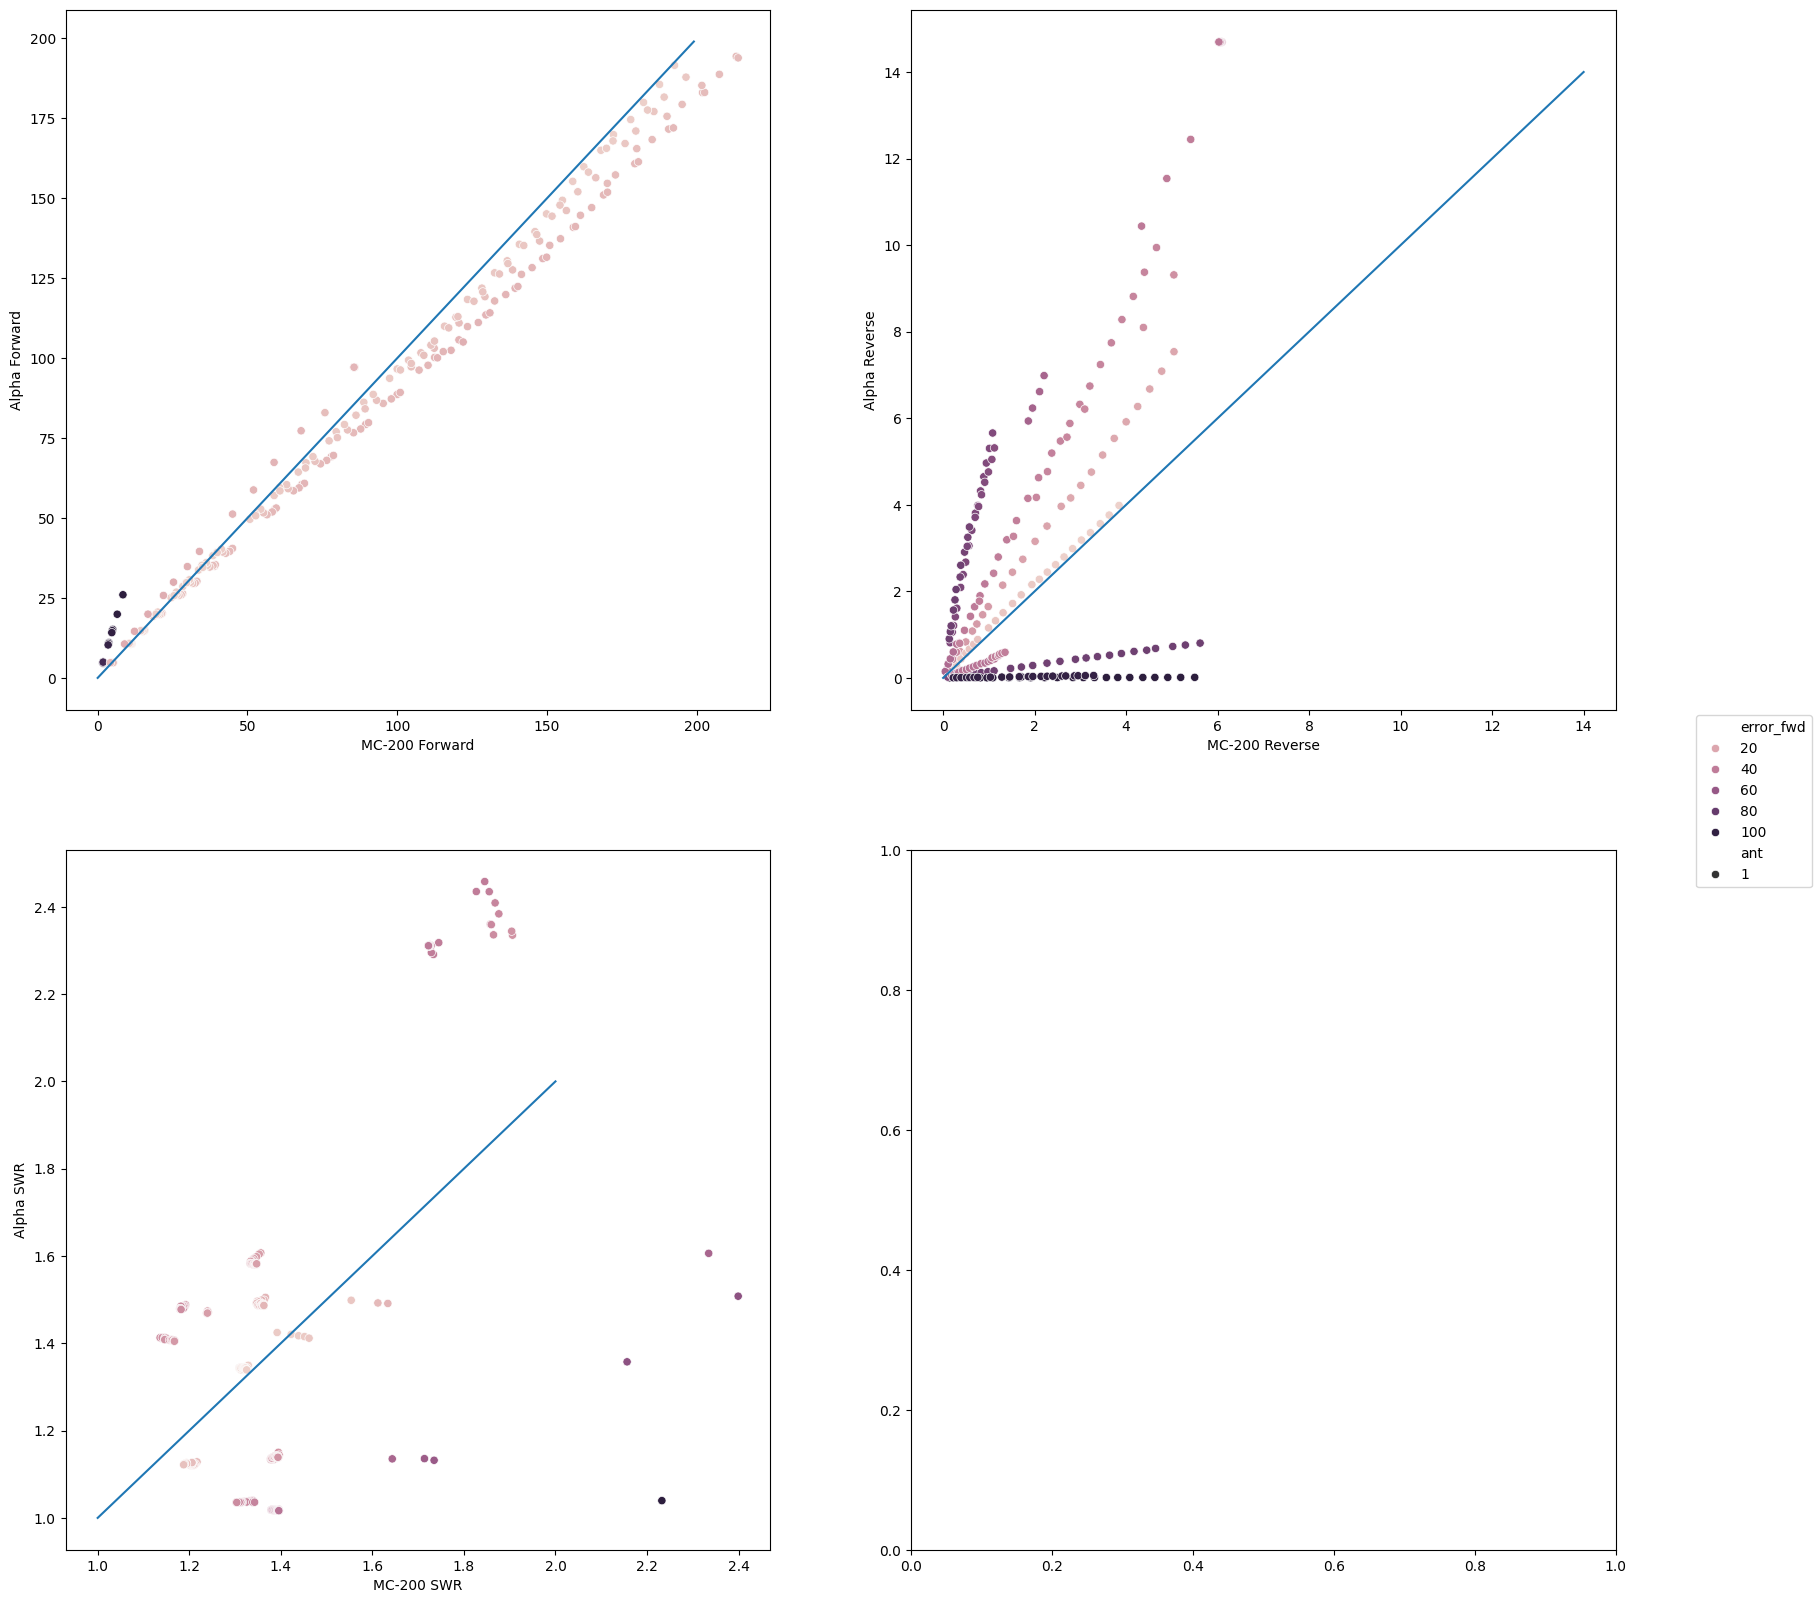

In [31]:
df = load_file('data.jsonl')

df = df.query('ant == 1')

fig, ax = plt.subplots(2, 2, figsize=(20, 20))


def make_line(a, *r):
    line = pd.DataFrame.from_records([{'x': i, 'y': i} for i in range(*r)])
    sns.lineplot(line, x='x', y='y', ax=a)


sns.scatterplot(df, x='MC-200 Forward', y='Alpha Forward', hue='error_fwd', style='ant', ax=ax[0, 0])
make_line(ax[0, 0], 200)

sns.scatterplot(df, x='MC-200 Reverse', y='Alpha Reverse', hue='error_rev', style='ant', ax=ax[0, 1])
make_line(ax[0, 1], 15)

sns.scatterplot(df, x='MC-200 SWR', y='Alpha SWR', hue='error_swr', style='ant', ax=ax[1, 0])
make_line(ax[1, 0], 1, 3)

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

ax[0, 0].get_legend().remove()
ax[0, 1].get_legend().remove()
ax[1, 0].get_legend().remove()
